In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from openpyxl import load_workbook
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import multiprocessing
import os
import time
import gloce as gc
from osgeo import gdal
from osgeo import gdalconst
from mpl_toolkits.basemap import Basemap
from glob import glob
from math import ceil
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
#return im_data, im_width, im_height, im_geotrans, im_proj
def read_img(filename):
    dt = gdal.Open(filename)
    im_width = dt.RasterXSize
    im_height = dt.RasterYSize
    im_bands = dt.RasterCount
    im_geotrans = dt.GetGeoTransform()
    im_proj = dt.GetProjection()
    im_data = dt.ReadAsArray(0,0,im_width,im_height)
    return im_data, im_width, im_height, im_geotrans, im_proj
def write_img(filename, im_proj, im_geotrans, im_data):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
spei_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/'
sm_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
soil_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
drv_path='//weili/User2/mxsun/CESS_230818/Pattern_drive/'
ele_path='//weili/User2/mxsun/CESS_230818/elephant_active_area/IUCN/'

# prepare data

## drought monthly mask

In [2]:
#---------combinding monthly droght region in 2015, 2016 and 1516---------
dr_month=read_img(spei_path+'drought_monthly_afr_record_240523_sub.tif')[0]
#根据monthly drought， 对应月份逐格点求drought resistance
#shape of dr_month is (24,1800,2080),2015-2016年逐月
dr_15=dr_month[:12,:,:]
dr_16=dr_month[12:,:,:]
print(dr_15.shape,dr_16.shape)
dr_16[dr_16==1]=2
dr_comb=dr_15+dr_16

# monthly drought mask for 2015
dr_mask15=np.copy(dr_comb)
dr_mask15[dr_mask15>1]=0
# monthly drought mask for 2016
dr_mask16=np.copy(dr_comb)
dr_mask16[dr_mask16!=2]=0
dr_mask16[dr_mask16==2]=1
# monthly drought mask for 2015 and 2016
dr_mask1516=np.copy(dr_comb)
dr_mask1516[dr_mask1516!=3]=0
dr_mask1516[dr_mask1516==3]=1

dr15=np.sum(dr_mask15,axis=0)
dr15[dr15>0]=1
dr16=np.sum(dr_mask16,axis=0)
dr16[dr16>0]=1
dr1516=np.sum(dr_mask1516,axis=0)
dr1516[dr1516>0]=1

(12, 6500, 7900) (12, 6500, 7900)


In [3]:
DEAA=read_img(spei_path+'SPEI_deaa001_240504.tif')[0]
DAA=read_img(spei_path+'SPEI_daa001_240504.tif')[0]
DEAA[DEAA==0]=np.nan
DAA[DAA==0]=np.nan

#dr15,dr16,dr1516,均没减去drought 2012-2014
#DEAA是drought only in 2015-2016, masked elephant region,可以用来mask
dr15[dr15==0]=np.nan
dr16[dr16==0]=np.nan
dr1516[dr1516==0]=np.nan

#DEAA相当于减去了2012-2014，因为DEAA是2015-2016 only的drought并mask elephant area
deaa15=dr15*DEAA
deaa16=dr16*DEAA
deaa1516=dr1516*DEAA
#deaa15,deaa16,deaa1516相加应该和DEAA区域完全匹配，已验证

## Resistance

In [4]:
ndvi15_res=read_img(spei_path+'ndvi_resistance_gs_2015_240525.tif')[0]
ndvi16_res=read_img(spei_path+'ndvi_resistance_gs_2016_240525.tif')[0]
ndvi1516_res=read_img(spei_path+'ndvi_resistance_gs_1516_240525.tif')[0]

csif15_res=read_img(spei_path+'sif_resistance_gs_2015_240525.tif')[0]
csif16_res=read_img(spei_path+'sif_resistance_gs_2016_240525.tif')[0]
csif1516_res=read_img(spei_path+'sif_resistance_gs_1516_240525.tif')[0]

ndvi15_res[ndvi15_res==0]=np.nan
csif15_res[csif15_res==0]=np.nan
ndvi16_res[ndvi16_res==0]=np.nan
csif16_res[csif16_res==0]=np.nan
ndvi1516_res[ndvi1516_res==0]=np.nan
csif1516_res[csif1516_res==0]=np.nan

## mask

In [5]:
dem=read_img(spei_path+'gtopoDEM_afr_001.tif')[0]
slope=read_img(spei_path+'gtopoSlope_afr_001.tif')[0]
dem=dem.astype(np.float32)
dem[dem==-9999]=np.nan
slope[slope==0]=np.nan

protec=read_img(drv_path+'WDPA_WDOECM_poly_Nov2023_AF_001_afr.tif')[0]
protec[protec>0]=1
protec=protec.astype(np.float32)
protec[protec==0]=np.nan

hfp = read_img(spei_path+'hfp2018_Afirca_001_230525.tif')[0]
hfp[hfp<=15]=1
hfp[hfp>1]=np.nan
mask=hfp#*protec
mask[~np.isnan(mask)]=1

#mask protected area
mask_protec=hfp#*protec
mask_protec[~np.isnan(mask_protec)]=1

np.nanmin(mask),np.nanmax(mask)

(1.0, 1.0)

# paired sites

In [6]:
#-----------------slide window 0.25°×0.25°-------------------
def slide_window_mean(s,dist,res):
    #s: window size
    #dist: disturb array
    #res: resistance and resilience array
    mean_arr=np.zeros((260,316))
    weight_arr=np.zeros((260,316))
    loc=np.zeros((260,316)) #record the location of supplied sites
    sl=np.ones((25,25))
    for i in range(260):
        #print("sliding", i, "line...")
        for j in range(316):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/625#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
                loc[i,j]=9
            else:
                bloc_dist_a=[] #should be 8 nums [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                res_dist_a=[] #should be 8 nums
                res_mask_pool=[]
                weight_pool=[]
                for m in [-1,1]:
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    bloc_dist_a.append(dist[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    res_dist_a.append(res[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                bloc_dist_a.append(dist[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                bloc_dist_a.append(dist[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                res_dist_a.append(res[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                res_dist_a.append(res[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                #the smooth order of a 9 value array is [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                for n in range(len(bloc_dist_a)): #the length is 8
                    res_mask_pool.append(np.multiply(bloc_dist_a[n],res_dist_a[n]))
                    weight_pool.append(np.count_nonzero(~np.isnan(res_mask_pool[n]))/625)#calculate the weight
                key=np.argmax(weight_pool) 
                # Key used to loc the supplied direction, the key-value consistience with [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                if weight_pool[key] > 0.05:
                    weight_arr[i,j]=weight_pool[key]
                    dt1=np.where(res_mask_pool[key]!=np.nan,res_mask_pool[key],np.nan)
                    mean_arr[i,j]=np.nanmean(dt1)#calculate the mean value
                    loc[i,j]=key+1
                else:
                    mean_arr[i,j]=np.nan#calculate the mean value
                    loc[i,j]=np.nan
    return mean_arr
#----------------kill NANs of array---------------------------
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a
def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1
#-------------15,16,1516,三个图层叠加--------------------------
def optimal_repets(f15_a,f16_a,f1516_a):
    #三个图层叠加，重叠的像素选最大/最小值
    m=f15_a*f16_a*f1516_a
    f15_a[np.isnan(f15_a)]=0
    f16_a[np.isnan(f16_a)]=0
    f1516_a[np.isnan(f1516_a)]=0
    f_comb_max=f15_a+f16_a+f1516_a
    f_comb_min=f15_a+f16_a+f1516_a
    for k in range(260):
        for j in range(316):
            if ~np.isnan(m[k,j]) == True:
                tt=np.sort([f15_a[k,j],f16_a[k,j],f1516_a[k,j]])
                #print(tt)
                f_comb_max[k,j]=tt[2]
                f_comb_min[k,j]=tt[0]
    return f_comb_max,f_comb_min

def optimal_mean(f15_a,f16_a,f1516_a):
    #三个图层叠加，重叠的像素优选1516map和15年map
    #保证输入数据的无效值为nan
    m=f15_a*f16_a*f1516_a
    m1=f15_a*f16_a
    m2=f15_a*f1516_a
    m3=f16_a*f1516_a
    
    f15_a[np.isnan(f15_a)]=0
    f16_a[np.isnan(f16_a)]=0
    f1516_a[np.isnan(f1516_a)]=0
    f_comb_mean=f15_a+f16_a+f1516_a#无重叠值的网格被各自年份的resistance填补，重叠值网格接下来会注意被重叠均值替代
    for k in range(260):
        for j in range(316):
            if ~np.isnan(m[k,j]) == True:#m[k,j]无重叠值的网格应该是nan
                f_comb_mean[k,j]=np.mean([f15_a[k,j],f16_a[k,j],f1516_a[k,j]])
            elif ~np.isnan(m1[k,j]) ==True:
                f_comb_mean[k,j]=np.mean([f15_a[k,j],f16_a[k,j]])
            elif ~np.isnan(m2[k,j]) ==True:
                f_comb_mean[k,j]=np.mean([f15_a[k,j],f1516_a[k,j]])
            elif ~np.isnan(m3[k,j]) ==True:
                f_comb_mean[k,j]=np.mean([f16_a[k,j],f1516_a[k,j]])         
    return f_comb_mean
#----------------dem mask----------------
def dd_mask(dem_differ,slo_differ):
    dem_differ[dem_differ<-200]=np.nan
    dem_differ[dem_differ>200]=np.nan
    dem_differ[~np.isnan(dem_differ)]=1
    slo_differ[slo_differ<-10]=np.nan
    slo_differ[slo_differ>10]=np.nan
    slo_differ[~np.isnan(slo_differ)]=1
    # 每一层数据位置对应,建立mask
    dd_mask15=np.ones((260,316))*dem_differ*slo_differ
    return dd_mask15

In [24]:
def paired_sites(dtt,dtt_name):#,option
    #dtt:[15年数据，16年数据，15-16年数据]
    #option:三个map重复优选方案，[0]:max,[1]:min
    #分别进行成对样点提取，最后合并，三张图会有一些边界重复提取的点，选取最优paired sites
    #-----drought&elephants mask----------
    res_pool1=[dtt[0],dem,slope]
    res_pool2=[dtt[1],dem,slope]
    res_pool3=[dtt[2],dem,slope]
    res_name1=[dtt_name[0],'dem15','slope15']
    res_name2=[dtt_name[1],'dem16','slope16']
    res_name3=[dtt_name[2],'dem','slope']
    dist_pool1=[deaa15*mask,DAA*mask] #2015 drought,[elephant,non-elephant] ###use lst15 ###简写d15
    dist_pool2=[deaa16*mask,DAA*mask] #2016 drought,[elephant,non-elephant] ###use lst16 ###简写d16
    dist_pool3=[deaa1516*mask,DAA*mask] #2016 drought,[elephant,non-elephant] ###use lst16 ###简写d16
    dist_name1=['DEAA15','DAA15']
    dist_name2=['DEAA16','DAA16']
    dist_name3=['DEAA1516','DAA1516']
    #--------------slide window------------------
    #列举需要计算的内部变量，和名称
    aa=[]
    aa_name=[]
    for m in range(2):
        for n in range(3):
            el=[25,dist_pool1[m],res_pool1[n]]
            aa.append(el)
            aa_name.append('driver_{}_{}_0.25deg_240527.npy'.format(dist_name1[m],res_name1[n]))
            #-------------the below can be removed if non-mutiyear variables -----------------
            el1=[25,dist_pool2[m],res_pool2[n]]
            aa.append(el1)
            aa_name.append('driver_{}_{}_0.25deg_240527.npy'.format(dist_name2[m],res_name2[n]))
            el2=[25,dist_pool3[m],res_pool3[n]]
            aa.append(el2)
            aa_name.append('driver_{}_{}_0.25deg_240527.npy'.format(dist_name3[m],res_name3[n]))

    for k in range(len(aa_name)):
        print('执行任务%s (%s)...' % (k, os.getpid()))
        kk=slide_window_mean(aa[k][0],aa[k][1],aa[k][2])
        np.save(spei_path+aa_name[k],kk)
    #--------------control dem<200 and slope<10------------------
    #2015年drought的DEMmask
    dem1=np.load(spei_path+'driver_DEAA15_dem15_0.25deg_240527.npy',allow_pickle=True)
    dem2=np.load(spei_path+'driver_DAA15_dem15_0.25deg_240527.npy',allow_pickle=True)
    slo1=np.load(spei_path+'driver_DEAA15_slope15_0.25deg_240527.npy',allow_pickle=True)
    slo2=np.load(spei_path+'driver_DAA15_slope15_0.25deg_240527.npy',allow_pickle=True)
    dem_differ=dem1-dem2
    slo_differ=slo1-slo2
    dd_mask15=dd_mask(dem_differ,slo_differ)
    #2016年drought的DEMmask
    dem1=np.load(spei_path+'driver_DEAA16_dem16_0.25deg_240527.npy',allow_pickle=True)
    dem2=np.load(spei_path+'driver_DAA16_dem16_0.25deg_240527.npy',allow_pickle=True)
    slo1=np.load(spei_path+'driver_DEAA16_slope16_0.25deg_240527.npy',allow_pickle=True)
    slo2=np.load(spei_path+'driver_DAA16_slope16_0.25deg_240527.npy',allow_pickle=True)
    dem_differ=dem1-dem2
    slo_differ=slo1-slo2
    dd_mask16=dd_mask(dem_differ,slo_differ)
    #2015-2016年重复drought的DEMmask
    dem1=np.load(spei_path+'driver_DEAA1516_dem_0.25deg_240527.npy',allow_pickle=True)
    dem2=np.load(spei_path+'driver_DAA1516_dem_0.25deg_240527.npy',allow_pickle=True)
    slo1=np.load(spei_path+'driver_DEAA1516_slope_0.25deg_240527.npy',allow_pickle=True)
    slo2=np.load(spei_path+'driver_DAA1516_slope_0.25deg_240527.npy',allow_pickle=True)
    dem_differ=dem1-dem2
    slo_differ=slo1-slo2
    dd_mask1516=dd_mask(dem_differ,slo_differ)
    #----------paired sites and significants-------------
    f15_a=np.load(spei_path+'driver_DEAA15_{}_0.25deg_240527.npy'.format(res_name1[0]),allow_pickle=True)*dd_mask15
    f16_a=np.load(spei_path+'driver_DEAA16_{}_0.25deg_240527.npy'.format(res_name2[0]),allow_pickle=True)*dd_mask16
    f1516_a=np.load(spei_path+'driver_DEAA1516_{}_0.25deg_240527.npy'.format(res_name3[0]),allow_pickle=True)*dd_mask1516
    #三个map可能有重复格点(选择三个map中最优（maximun or minimun）)
    f_a=optimal_mean(f15_a,f16_a,f1516_a)
    f15_b=np.load(spei_path+'driver_DAA15_{}_0.25deg_240527.npy'.format(res_name1[0]),allow_pickle=True)*dd_mask15
    f16_b=np.load(spei_path+'driver_DAA16_{}_0.25deg_240527.npy'.format(res_name2[0]),allow_pickle=True)*dd_mask16
    f1516_b=np.load(spei_path+'driver_DAA1516_{}_0.25deg_240527.npy'.format(res_name3[0]),allow_pickle=True)*dd_mask1516
    f_b=optimal_mean(f15_b,f16_b,f1516_b)
    
    f_a[f_a==0]=np.nan
    f_b[f_b==0]=np.nan
    #求mean difference
    delta=f_a-f_b
    #delta_m=(f_a+f_b)/2
    res_delta=np.nanmean(delta)
    print(res_delta)
    #求significants
    ddt=del_nan(f_a,f_b)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    pp_value=p
    return delta,pp_value,f_a,f_b

In [28]:
ddt_ndvi_res=[ndvi15_res,ndvi16_res,ndvi1516_res]
ddt_csif_res=[csif15_res,csif16_res,csif1516_res]
ddt_ndvi_res_name=["ndvi15_res","ndvi16_res","ndvi_res"]
ddt_csif_res_name=["csif15_res","csif16_res","csif_res"]

ddt=[ddt_ndvi_res,ddt_csif_res]
ddt_name=[ddt_ndvi_res_name,ddt_csif_res_name]
#treeH,tc,Bio,soc,clay,bulk,et,lst,spei,ndvi_res,csif_res
#option=[[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1]]

delta_dif=[]
p_value=[]
d_DEAA=[]
d_DAA=[]
for i in range(2):
    tt=paired_sites(ddt[i],ddt_name[i])#,option[i]
    delta_dif.append(tt[0])
    p_value.append(tt[1])
    d_DEAA.append(tt[2])
    d_DAA.append(tt[3])

执行任务0 (85952)...
执行任务1 (85952)...
执行任务2 (85952)...
执行任务3 (85952)...
执行任务4 (85952)...
执行任务5 (85952)...
执行任务6 (85952)...
执行任务7 (85952)...
执行任务8 (85952)...
执行任务9 (85952)...
执行任务10 (85952)...
执行任务11 (85952)...
执行任务12 (85952)...
执行任务13 (85952)...
执行任务14 (85952)...
执行任务15 (85952)...
执行任务16 (85952)...
执行任务17 (85952)...
0.00400279872628778
执行任务0 (85952)...
执行任务1 (85952)...
执行任务2 (85952)...
执行任务3 (85952)...
执行任务4 (85952)...
执行任务5 (85952)...
执行任务6 (85952)...
执行任务7 (85952)...
执行任务8 (85952)...
执行任务9 (85952)...
执行任务10 (85952)...
执行任务11 (85952)...
执行任务12 (85952)...
执行任务13 (85952)...
执行任务14 (85952)...
执行任务15 (85952)...
执行任务16 (85952)...
执行任务17 (85952)...
0.0038136304862251887


In [29]:
p_value

[0.0012928357709352778, 0.07847483303309717]

In [26]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

res_delta=[]
for i in range(2):
    res_delta.append(kill_nan(delta_dif[i]))
np.mean(res_delta[0]),np.mean(res_delta[1])

(0.00400279872628778, 0.00381363048622519)

In [44]:
len(res_delta[0])

2828

## Fig

0.00400279872628778 [8.64687416]
0.00381363048622519 [5.37542258]


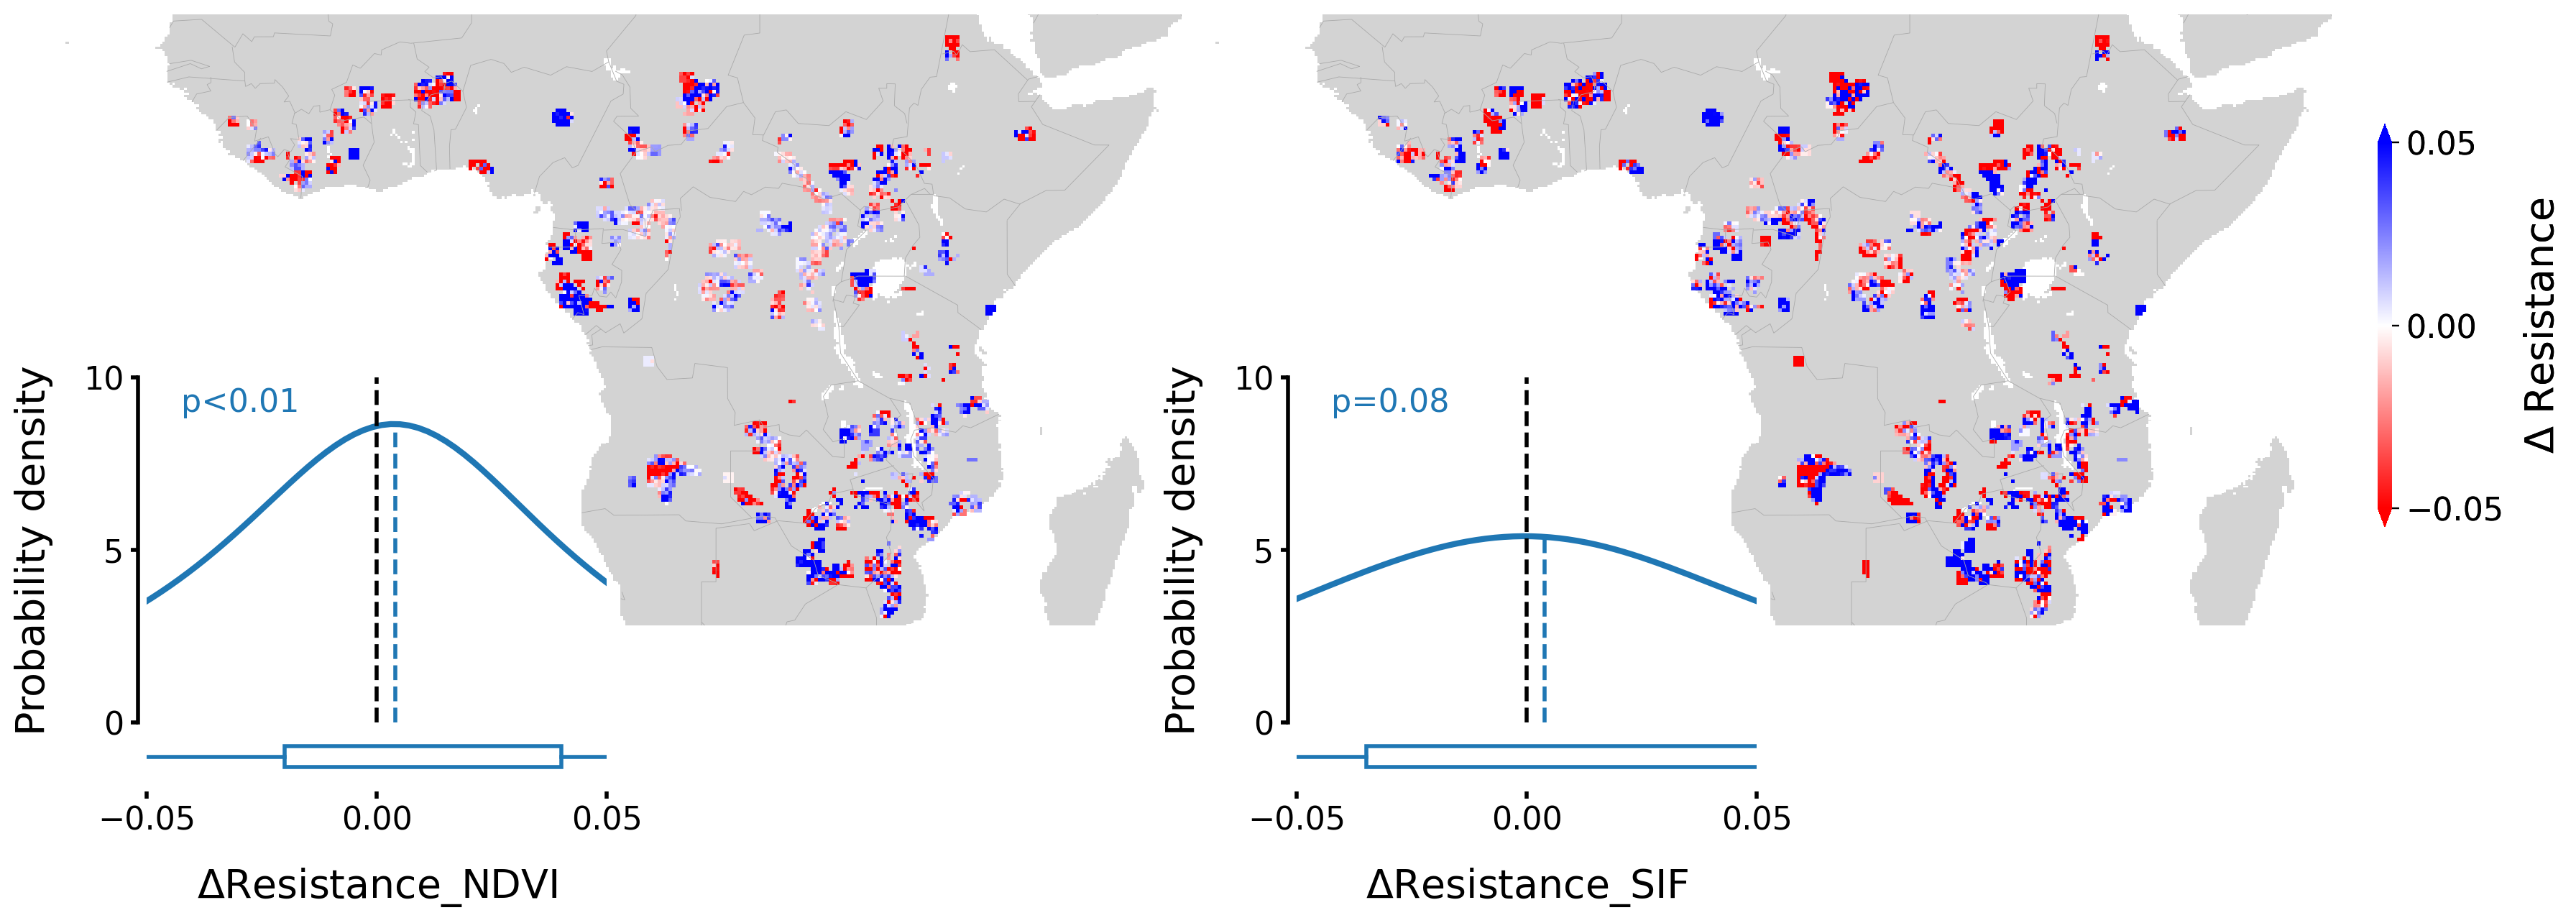

In [42]:
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
#fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16,12), sharex=False,sharey=False)
#return im_data, im_width, im_height, im_geotrans, im_proj
#(-25.37, 37.36, 51.42, -46.980000000000004)
#(-26.0, 25.0, 53.0, -40.0)
lon1 = -26
lon2 = 53
lat1 = -25
lat2 = 17

left, bottom, width, hegiht= 0, 0, 0.5,1
left1, bottom1, width1, hegiht1= 0.5, 0, 0.5,1
loc=[[left, bottom, width, hegiht],[left1, bottom1, width1, hegiht1]]
left2, bottom2, width2, hegiht2= 0.05, 0.15, 0.2,0.3
left3, bottom3, width3, hegiht3= 0.55, 0.15, 0.2,0.3
loc1=[[left2, bottom2, width2, hegiht2],[left3, bottom3, width3, hegiht3]]


#pp=[p_delta_LA[1],p_delta_LA[0]]
#pp1=[p_delta_LC[1],p_delta_LC[0]]
cl= np.array([(112,173,71),(169,209,142)])
cl1 = np.array([(251,153,143),(248,203,173)])
cl=cl/255
cl1=cl1/255
cl2=['C0','salmon']
res_name=['ndvi_res','csif_res']

fig = plt.figure(figsize=(16,8)) ##width, height default(8,6)
label=['$\Delta$ Resistance']
text=['a','b']
for i in range(2):
    ax = fig.add_subplot(loc[i])
    m = Basemap(llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2,ax=ax)
    m.drawlsmask(land_color='lightgray',ocean_color='none',lakes=True)
    m.drawcountries(linewidth=0.30, color='darkgrey')
    #m.drawmapboundary(fill_color='skyblue')
    #m.drawcoastlines(linewidth=0.50, color='black',zorder=40)
    norm = mcolors.TwoSlopeNorm(vmin=-0.05, vmax = 0.05, vcenter=0)
    im = m.imshow(delta_dif[i][32:200],cmap ='bwr_r',origin='upper',norm=norm)
    #im1 = m.imshow(LC_data[i],cmap ='bwr_r',origin='upper',norm=norm)
    #remove the broder of figure
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #ax.text(0.01,0.9-i*0.008, text[i], transform = ax.transAxes,color='black',fontsize=18)

    #position=fig.add_axes([0.15])
    position=fig.add_axes([1.02,0.32,0.006,0.35])#左、底、宽、高
    #position=fig.add_axes([0.38,0.08,0.25,0.01])#左、底、宽、高
    cb=fig.colorbar(im,ax=ax,extend='both',shrink=0.3,pad=0.01,cax=position)#orientation='horizontal',
    cb.set_label(label[0],fontsize=20,labelpad=10)
    cb.ax.tick_params(labelsize=16) 
    cb.set_ticks(np.arange(-0.05,0.051,0.05)) 
    cb.outline.set_visible(False)
    #--------------------------------------添加 子图， pdf----------------------------------------------#
    ax1=fig.add_subplot(loc1[i])
    x=np.linspace(-1,1,1000)
    mean=np.nanmean(res_delta[i])
    delta_rav=gc.nanravel(res_delta[i])
    kenal=gaussian_kde(delta_rav)
    z=kenal.evaluate(x)
    z_mean=kenal.evaluate(mean)
    print(mean,z_mean)

    xlabel=['$\Delta$Resistance_NDVI','$\Delta$Resistance_SIF']
    ax1.plot(x,z,lw=3,color='C0')
    ax1.vlines(mean,0,z_mean,lw=2,ls='--',color='C0')
    ax1.vlines(0,0,25,lw=2,ls='--',color='black')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    if p_value[i]<0.001:
        ax1.text(0.13,0.35, "p<0.001", fontsize=16,transform = ax.transAxes,color='C0')
    elif p_value[i]<0.01:
        ax1.text(0.13,0.35, "p<0.01", fontsize=16,transform = ax.transAxes,color='C0')
    elif p_value[i]<0.05:
        ax1.text(0.13,0.35, "p<0.05", fontsize=16,transform = ax.transAxes,color='C0')
    else:
        ax1.text(0.13,0.35, "p={:.2f}".format(p_value[i]), fontsize=16,transform = ax.transAxes,color='C0')
    #ax1.legend(fontsize=12,loc='upper left',frameon=False)
    #ax1.legend(fontsize=12,loc='upper left',frameon=False)

    ax1=plt.gca()
    ax1.yaxis.set_ticks_position('left')
    ax1.spines['left'].set_position(('data',-0.052))
    ax1.xaxis.set_ticks_position('bottom')
    ax1.spines['bottom'].set_position(('data',-2))
    ax1.set_ylim(0,10)
    ax1.set_xlim(-0.05,0.05)
    ax1.set_xticks(np.arange(-0.05,0.051,0.05))
    ax1.set_yticks(np.arange(0,10.1,5))
    ax1.set_ylabel('Probability density',labelpad=15)
    ax1.set_xlabel(xlabel[i],labelpad=15)
    ax1.tick_params(labelsize=16)
    ax1.xaxis.label.set_size(20)
    ax1.yaxis.label.set_size(20)
    ax1.xaxis.set_tick_params(width=2)
    ax1.yaxis.set_tick_params(width=2)
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    #ax.text(0.05,0.95, text[i], fontsize=24,family='SimHei',weight='black',color='black',transform = ax.transAxes)
    ax1.set(facecolor='none')
    if i ==0:
        ax2=fig.add_axes([0.05,0.09,0.2,0.06])#左，底，宽，高
        ax2.set_xlim(-0.05,0.05)
        ax2.set_xticks(np.arange(-0.05,0.05,0.05))
        ax2.axis('off')
    else:
        ax2=fig.add_axes([0.55,0.09,0.2,0.06])#左，底，宽，高
        ax2.set_xlim(-0.05,0.05)
        ax2.set_xticks(np.arange(-0.05,0.05,0.05))
        ax2.axis('off')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.tick_params(bottom=True,top=False, left=False, right=False)#隐藏刻度线
    ax2.spines['bottom'].set_visible(True)
    bplot=ax2.boxplot(kill_nan(res_delta_daaP[i]),
                      vert=False,
                      whis=(10,90),                
                      widths=0.3,
                      patch_artist=True,
                      showmeans=False,
                      meanprops = {'marker':'o','markerfacecolor':'C0',"markeredgecolor":'C0',"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                      medianprops={'linewidth':'0.5',"color":'C0',"alpha":0},
                      boxprops={"facecolor": 'none', "edgecolor": 'C0',"linewidth":2,"alpha":1},
                      capprops=None,
                      whiskerprops={'linewidth':'2','color':'C0'},
                      showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示
                      showfliers = False,
                      flierprops = {'marker':'+','markersize':'3','markeredgecolor':'C0','color':'C0'})
    ax2.set(facecolor='none')

#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/Fig1_resistance patterns_main_240116.tif", dpi=600, bbox_inches = 'tight')

# Growth reduction area

In [43]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

res_delta_daaP=[]
mm=[]
for i in range(2):
    tt=np.copy(d_DAA[i])
    tt[tt>1]=np.nan
    tt[tt<=1]=1
    print(np.nanmax(tt))
    mm.append(tt)
    res_delta_daaP.append(delta_dif[i]*tt)
np.nanmean(res_delta_daaP[0]),np.nanmean(res_delta_daaP[1])

1.0
1.0


(0.013144678041088148, 0.016732050701014786)

In [48]:
np.count_nonzero(~np.isnan(res_delta_daaP[0]))

2258

In [36]:
pp_value=[]

def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

for i in range(2):
    f1=np.array(d_DEAA)
    f2=np.array(d_DAA)
    ddt=del_nan(f1,f2)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    pp_value.append(p)
pp_value #p value of ndvi_res and csif_res

[0.0010703916263030493, 0.0010703916263030493]

## Fig

0.013144678041088148 [8.24931409]
0.016732050701014786 [5.31295336]


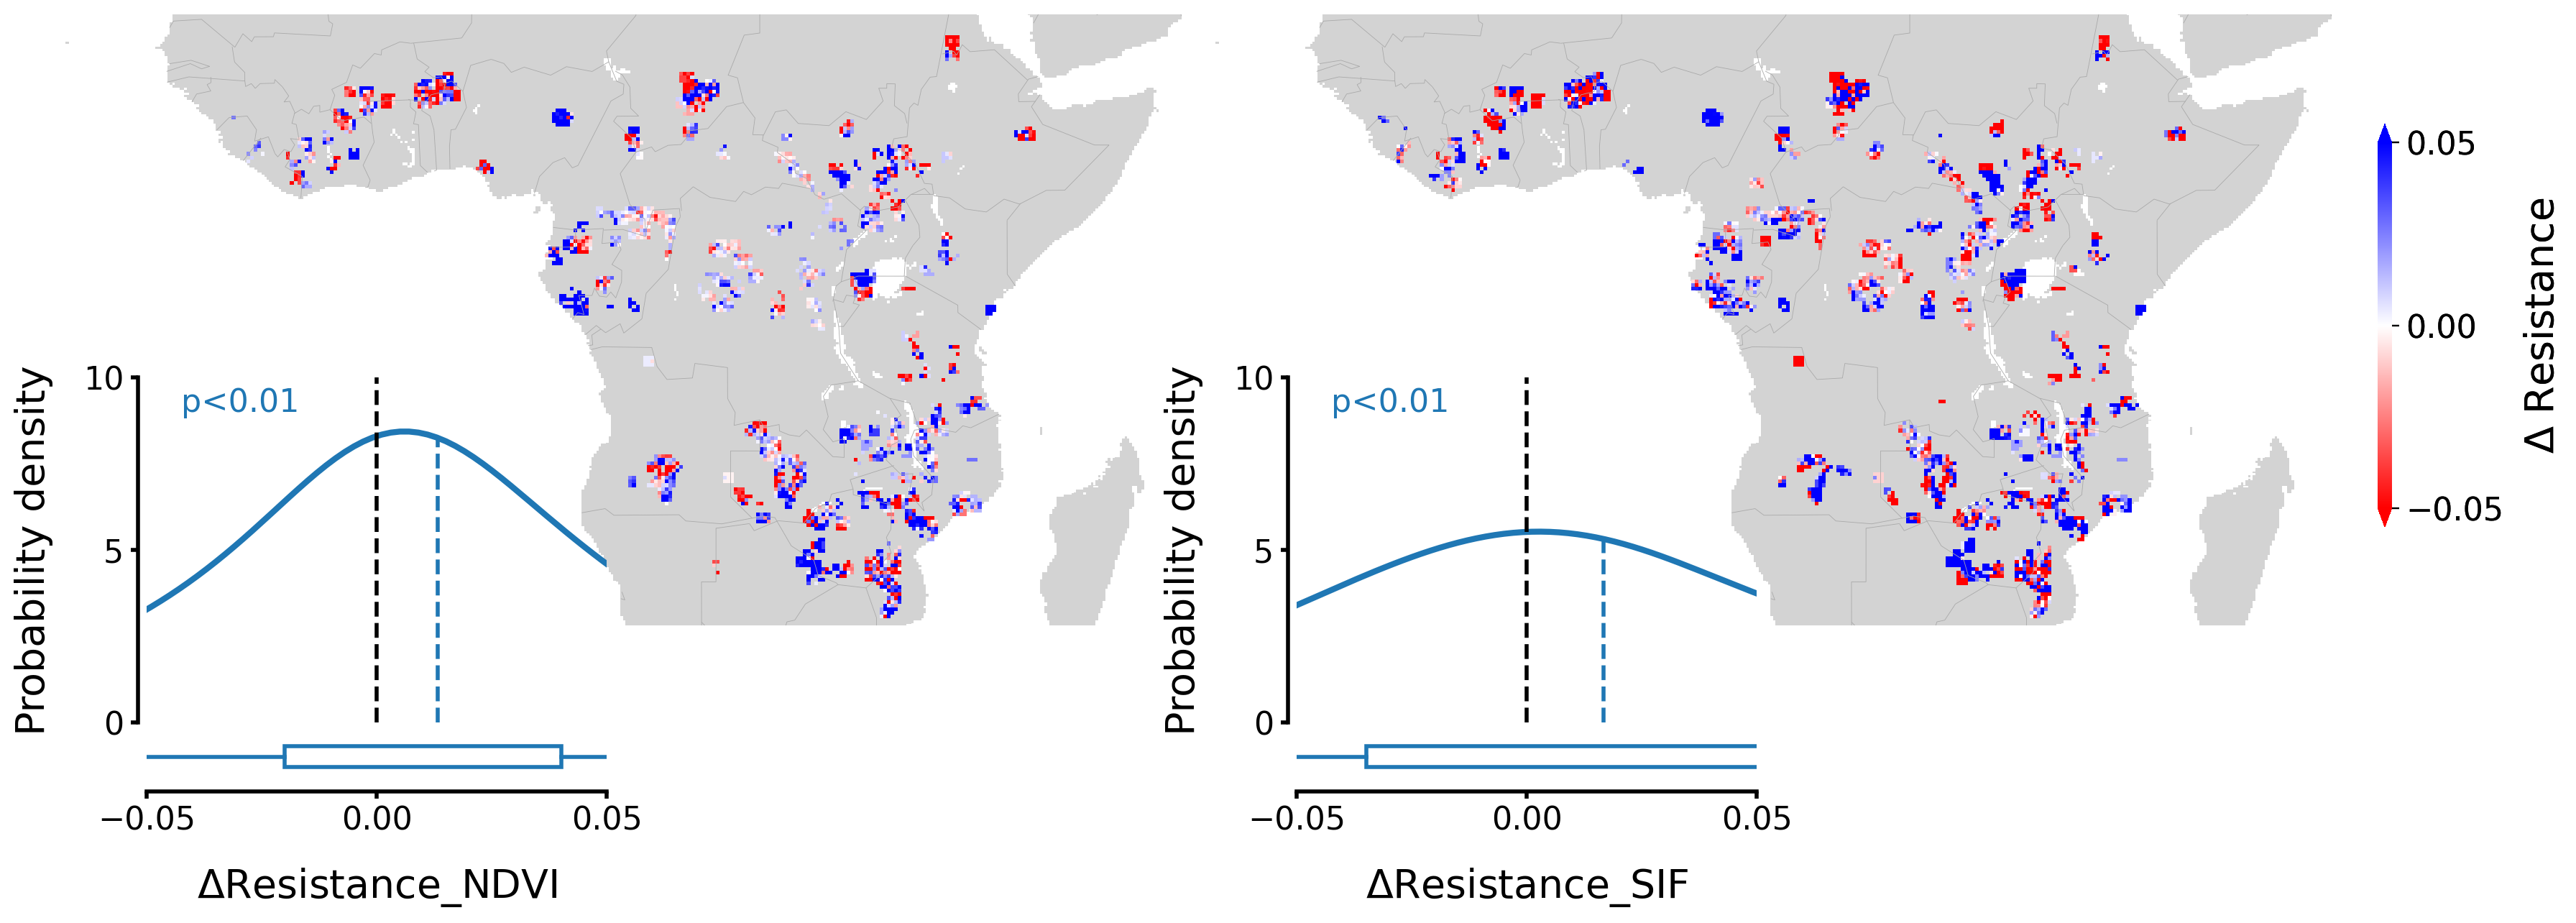

In [41]:
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
#fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16,12), sharex=False,sharey=False)
#return im_data, im_width, im_height, im_geotrans, im_proj
#(-25.37, 37.36, 51.42, -46.980000000000004)
#(-26.0, 25.0, 53.0, -40.0)
lon1 = -26
lon2 = 53
lat1 = -25
lat2 = 17

left, bottom, width, hegiht= 0, 0, 0.5,1
left1, bottom1, width1, hegiht1= 0.5, 0, 0.5,1
loc=[[left, bottom, width, hegiht],[left1, bottom1, width1, hegiht1]]
left2, bottom2, width2, hegiht2= 0.05, 0.15, 0.2,0.3
left3, bottom3, width3, hegiht3= 0.55, 0.15, 0.2,0.3
loc1=[[left2, bottom2, width2, hegiht2],[left3, bottom3, width3, hegiht3]]


#pp=[p_delta_LA[1],p_delta_LA[0]]
#pp1=[p_delta_LC[1],p_delta_LC[0]]
cl= np.array([(112,173,71),(169,209,142)])
cl1 = np.array([(251,153,143),(248,203,173)])
cl=cl/255
cl1=cl1/255
cl2=['C0','salmon']
res_name=['ndvi_res','csif_res']

fig = plt.figure(figsize=(16,8)) ##width, height default(8,6)
label=['$\Delta$ Resistance']
text=['a','b']
for i in range(2):
    ax = fig.add_subplot(loc[i])
    m = Basemap(llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2,ax=ax)
    m.drawlsmask(land_color='lightgray',ocean_color='none',lakes=True)
    m.drawcountries(linewidth=0.30, color='darkgrey')
    #m.drawmapboundary(fill_color='skyblue')
    #m.drawcoastlines(linewidth=0.50, color='black',zorder=40)
    norm = mcolors.TwoSlopeNorm(vmin=-0.05, vmax = 0.05, vcenter=0)
    im = m.imshow(res_delta_daaP[i][32:200],cmap ='bwr_r',origin='upper',norm=norm)
    #im1 = m.imshow(LC_data[i],cmap ='bwr_r',origin='upper',norm=norm)
    #remove the broder of figure
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #ax.text(0.01,0.9-i*0.008, text[i], transform = ax.transAxes,color='black',fontsize=18)

    #position=fig.add_axes([0.15])
    position=fig.add_axes([1.02,0.32,0.006,0.35])#左、底、宽、高
    #position=fig.add_axes([0.38,0.08,0.25,0.01])#左、底、宽、高
    cb=fig.colorbar(im,ax=ax,extend='both',shrink=0.3,pad=0.01,cax=position)#orientation='horizontal',
    cb.set_label(label[0],fontsize=20,labelpad=10)
    cb.ax.tick_params(labelsize=16) 
    cb.set_ticks(np.arange(-0.05,0.051,0.05)) 
    cb.outline.set_visible(False)
    #--------------------------------------添加 子图， pdf----------------------------------------------#
    ax1=fig.add_subplot(loc1[i])
    x=np.linspace(-1,1,1000)
    mean=np.nanmean(kill_nan(res_delta_daaP[i]))
    delta_rav=gc.nanravel(kill_nan(res_delta_daaP[i]))
    kenal=gaussian_kde(delta_rav)
    z=kenal.evaluate(x)
    z_mean=kenal.evaluate(mean)
    print(mean,z_mean)

    xlabel=['$\Delta$Resistance_NDVI','$\Delta$Resistance_SIF']
    ax1.plot(x,z,lw=3,color='C0')
    ax1.vlines(mean,0,z_mean,lw=2,ls='--',color='C0')
    ax1.vlines(0,0,25,lw=2,ls='--',color='black')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    #ax1.spines['bottom'].set_visible(False)
    if pp_value[i]<0.001:
        ax1.text(0.13,0.35, "p<0.001", fontsize=16,transform = ax.transAxes,color='C0')
    elif pp_value[i]<0.01:
        ax1.text(0.13,0.35, "p<0.01", fontsize=16,transform = ax.transAxes,color='C0')
    elif pp_value[i]<0.05:
        ax1.text(0.13,0.35, "p<0.05", fontsize=16,transform = ax.transAxes,color='C0')
    else:
        ax1.text(0.13,0.35, "p={:.2f}".format(p_value[i]), fontsize=16,transform = ax.transAxes,color='C0')
    #ax1.legend(fontsize=12,loc='upper left',frameon=False)
    #ax1.legend(fontsize=12,loc='upper left',frameon=False)

    ax1=plt.gca()
    ax1.yaxis.set_ticks_position('left')
    ax1.spines['left'].set_position(('data',-0.052))
    ax1.xaxis.set_ticks_position('bottom')
    ax1.spines['bottom'].set_position(('data',-2))
    ax1.set_ylim(0,10)
    ax1.set_xlim(-0.05,0.05)
    ax1.set_xticks(np.arange(-0.05,0.051,0.05))
    ax1.set_yticks(np.arange(0,10.1,5))
    ax1.set_ylabel('Probability density',labelpad=15)
    ax1.set_xlabel(xlabel[i],labelpad=15)
    ax1.tick_params(labelsize=16)
    ax1.xaxis.label.set_size(20)
    ax1.yaxis.label.set_size(20)
    ax1.xaxis.set_tick_params(width=2)
    ax1.yaxis.set_tick_params(width=2)
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    #ax.text(0.05,0.95, text[i], fontsize=24,family='SimHei',weight='black',color='black',transform = ax.transAxes)
    ax1.set(facecolor='none')
    #position=fig.add_axes([1.02,0.32,0.006,0.35])#左、底、宽
    if i ==0:
        ax2=fig.add_axes([0.05,0.09,0.2,0.06])#左，底，宽，高
        ax2.set_xlim(-0.05,0.05)
        ax2.set_xticks(np.arange(-0.05,0.05,0.05))
        ax2.axis('off')
    else:
        ax2=fig.add_axes([0.55,0.09,0.2,0.06])#左，底，宽，高
        ax2.set_xlim(-0.05,0.05)
        ax2.set_xticks(np.arange(-0.05,0.05,0.05))
        ax2.axis('off')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.tick_params(bottom=True,top=False, left=False, right=False)#隐藏刻度线
    ax2.spines['bottom'].set_visible(True)
    bplot=ax2.boxplot(kill_nan(res_delta_daaP[i]),
                      vert=False,
                      whis=(10,90),                
                      widths=0.3,
                      patch_artist=True,
                      showmeans=False,
                      meanprops = {'marker':'o','markerfacecolor':'C0',"markeredgecolor":'C0',"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                      medianprops={'linewidth':'0.5',"color":'C0',"alpha":0},
                      boxprops={"facecolor": 'none', "edgecolor": 'C0',"linewidth":2,"alpha":1},
                      capprops=None,
                      whiskerprops={'linewidth':'2','color':'C0'},
                      showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示
                      showfliers = False,
                      flierprops = {'marker':'+','markersize':'3','markeredgecolor':'C0','color':'C0'})
    ax2.set(facecolor='none')

#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/Fig1_resistance patterns_main_240116.tif", dpi=600, bbox_inches = 'tight')